# 09.05 A Complete Procedure

Classification issues on the Olivetti faces are hard to visualize because out classes are just numbers.
Let's use the Labeled Faces in the Wild dataset again,
since we can recognize some of the people in there by ourselves.

![Tony Blair](sl-tony-blair.svg)

<div style="text-align:right;"><sup>sl-tony-blair.svg</sup></div>

LFW is a much harder dataset:
the faces are in different orientations and the support of distinct classes vary considerably.
This is close to a real world problem, therefore let's treat it as such.
For a while we have been relying on cross-validation to check our models but for real world data,
where we expect to have new (previously unknown) data thrown at our classifier.
This is often not enough because as our grid search increases to more hyperparemeters
we are risking overfitting the hyperparameters to our model.
For this problem we will use three sets: **a training set, a validation set and a test set**.

We will still use SVMs and PCA here for dealing with faces, we import these.
Also we take the common libraries and the LFW dataset.
The model selection procedures we will import as we go.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-talk')
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=50)
len(faces.data), faces.target_names

(1560,
 array(['Ariel Sharon', 'Colin Powell', 'Donald Rumsfeld', 'George W Bush',
        'Gerhard Schroeder', 'Hugo Chavez', 'Jacques Chirac',
        'Jean Chretien', 'John Ashcroft', 'Junichiro Koizumi',
        'Serena Williams', 'Tony Blair'], dtype='<U17'))

We saw this before, but just in case let's look at the images.
The `y=` argument to title allows us to place it at the bottom.

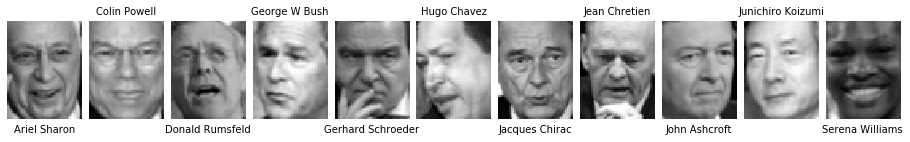

In [2]:
fig, axes = plt.subplots(1, 11, figsize=(16, 3))
fig.subplots_adjust(hspace=0.1, wspace=0.1)
first_img = [np.argmax(faces.target == x) for x in list(range(len(faces.target_names)))]
for i, ax in enumerate(axes.flat):
    idx = first_img[i]
    ax.imshow(faces.data[idx].reshape(62, 47), cmap='gray')
    if i % 2:
        ax.set_title(faces.target_names[i], fontsize=10)
    else:
        ax.set_title(faces.target_names[i], fontsize=10, y=-0.2)
    ax.axis('off')

First let's flense out a test set.
We will not touch this set until we have a trained model with tuned hyperparameters.
Then we will use this set to estimate the generalization of the model against
data that it has never seen.

This is quite different from how we used the `train_test_split` procedure before.
When we saw the procedure the first time it did appear to be a poor man's cross validation splitter.
The main purpose of this procedure is to take out the test set,
a test set which will not be touched by cross validation.
The naming convention of *test set* and *validation set* vary in literature,
some people call the set taken out before the cross validation the test set
and some people call it the validation set.
Unfortunately machine learning is full of not well defined naming conventions.
Beware!
What is really important to remember is that one set is split from the dataset
before cross validation.
During the cross validation the remaining dataset is split into folds
and the model is repeatedly tested on all but one fold,
and then tested on the remaining fold.
Rinse-repeat for each fold during cross validation.

In [3]:
from sklearn.model_selection import train_test_split

xtrain, xtest, ytrain, ytest = train_test_split(faces.data, faces.target, test_size=0.2)

Now we train the model as normal, and perform cross-validation.
We will try different kernels, let's see which kernel will perform best.
The grid search with shuffling allow us to be reasonably
confident of the cross validation.

The following is still a big problem that will take a while when run.

In [4]:
from sklearn.model_selection import KFold, GridSearchCV

model = make_pipeline(PCA(n_components=128, svd_solver='randomized'), SVC())
param_grid = [
    {'svc__kernel': ['linear'], 'svc__C': [1, 10, 100]},
    {'svc__kernel': ['rbf'], 'svc__C': [1, 10, 100], 'svc__gamma': [0.1, 1.0, 10.0]}
]
grid = GridSearchCV(model, param_grid, cv=KFold(n_splits=5, shuffle=True))
grid.fit(xtrain, ytrain)
grid.best_score_, grid.best_estimator_

(0.7691983935742972,
 Pipeline(memory=None,
          steps=[('pca',
                  PCA(copy=True, iterated_power='auto', n_components=128,
                      random_state=None, svd_solver='randomized', tol=0.0,
                      whiten=False)),
                 ('svc',
                  SVC(C=10, break_ties=False, cache_size=200, class_weight=None,
                      coef0=0.0, decision_function_shape='ovr', degree=3,
                      gamma='scale', kernel='linear', max_iter=-1,
                      probability=False, random_state=None, shrinking=True,
                      tol=0.001, verbose=False))],
          verbose=False))

But plain score, be it mean accuracy or F1 does not tell us much in a multiclass problem.
Instead a classification report would better capture the model performance.

Moreover, we are really interested in how the model *generalizes*,
we should test is against the *test set* which we kept untouched until now.

In [5]:
from sklearn.metrics import classification_report

y_hat = grid.best_estimator_.predict(xtest)
print(classification_report(ytest, y_hat, target_names=faces.target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.72      0.62      0.67        21
     Colin Powell       0.71      0.80      0.75        51
  Donald Rumsfeld       0.74      0.80      0.77        25
    George W Bush       0.87      0.86      0.86        98
Gerhard Schroeder       0.82      0.78      0.80        23
      Hugo Chavez       0.89      0.73      0.80        11
   Jacques Chirac       0.62      0.62      0.62         8
    Jean Chretien       0.60      0.67      0.63         9
    John Ashcroft       0.75      0.69      0.72        13
Junichiro Koizumi       0.94      0.89      0.91        18
  Serena Williams       0.80      1.00      0.89         8
       Tony Blair       0.83      0.74      0.78        27

         accuracy                           0.79       312
        macro avg       0.77      0.77      0.77       312
     weighted avg       0.80      0.79      0.79       312



We have a reasonable F1 score across all classes.
There are differences where the support is poor.
But also people who tend to have a very different face from the others have a very good F1 score.
This is likely to mean that our classifier is doing what is supposed to do.
Another way of visualizing this is a confusion matrix.

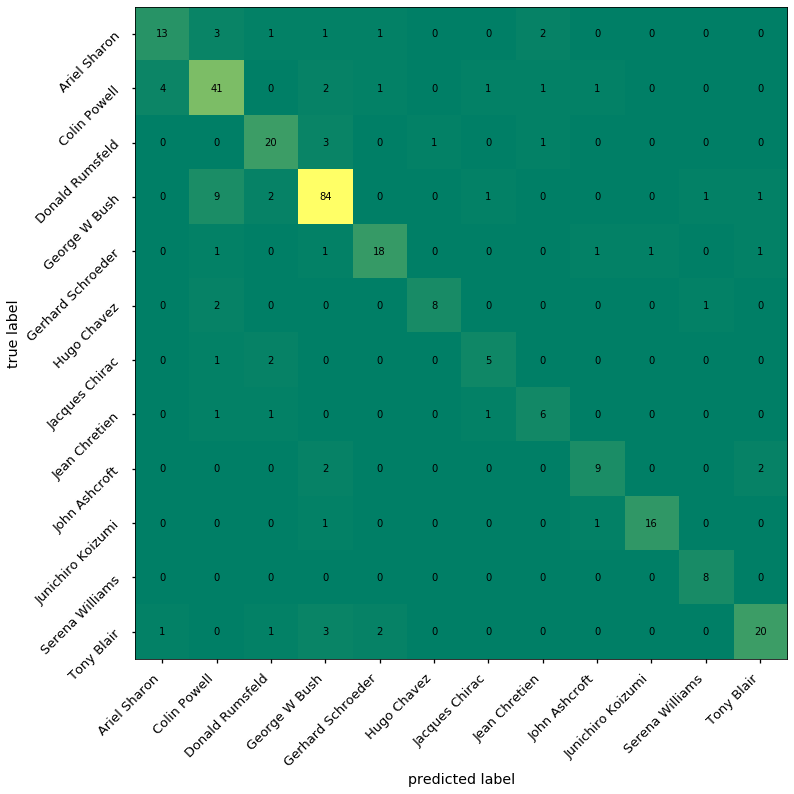

In [6]:
from sklearn.metrics import confusion_matrix

mat = confusion_matrix(ytest, y_hat)
fig, ax = plt.subplots(figsize=(12, 12))
cax = ax.matshow(mat, cmap='summer')
ticks = np.arange(0,len(faces.target_names))
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(faces.target_names, rotation=45, ha='right')
ax.set_yticklabels(faces.target_names, rotation=45, ha='right')
ax.set_ylabel('true label')
ax.set_xlabel('predicted label')
ax.xaxis.set_ticks_position('bottom')

for i in range(mat.shape[0]):
    for j in range(mat.shape[1]):
        ax.text(j, i, mat[i, j], ha='center', va='center')

That is a similar picture, we can say that the generalization is good enough.
SVMs are quite a good model for this kind of problem.
On supervised learning problems we expect the main diagonal
to be populated in the confusion matrix.
We can more-or-less see the main diagonal populated,
it is just the support for the class containing photos of George W Bush
is so high that the colors of the colormap cannot cope.
Still we have a good classification because the values
outside the main diagonal are small.

Let's see how good.
We can identify the faces on the pictures ourselves
(or cheat and read it from the original dataset),
and we can compare that against how our model did.

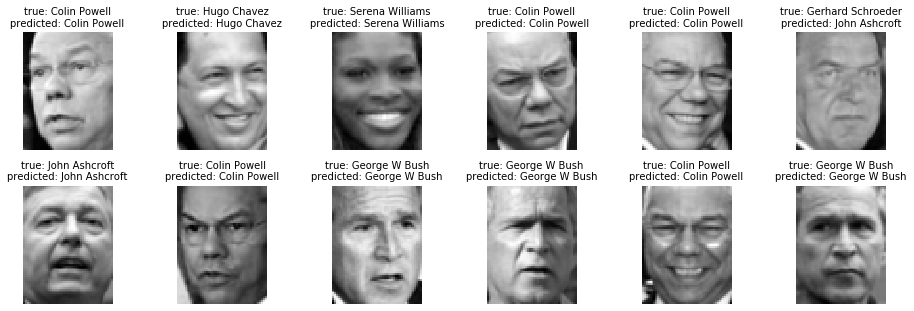

In [7]:
fig, axes = plt.subplots(2, 6, figsize=(16, 5))
fig.subplots_adjust(hspace=0.3, wspace=0.3)
names = faces.target_names
for i, ax in enumerate(axes.flat):
    ax.imshow(xtest[i].reshape(62, 47), cmap='gray')
    ax.set_title('true: %s\npredicted: %s' % (names[ytest[i]], names[y_hat[i]]), fontsize=10)
    ax.axis('off')

For such a small amount of code is tis quite a powerful model.

## Further Evaluation

The three sets to evaluate a real world problem are a good enough standard for most problems.
That said there are more advanced techniques.
The model complexity found by tuning the hyperparameters is not constant
when we add more data points.
In other words, we can prove that a problem is solvable by sampling our data points;
but we cannot argue that a model tuned to use certain hyperparameters
will perform (generalize) as well on new data.

If we have enough data to worry about the training time,
we can use a **learning curve** to estimate how well our hyperparameters,
tuned on small samples will perform on the full dataset.
The *total variance in the dataset is directly proportional
to the number of samples needed to explain this variance*.
Therefore, if we train and tune our model on increasingly bigger samples of our dataset,
the score of the model on its training data and its test set will converge.
Once this converges we can be confident that we have found the number of samples
needed to account for the entire variance in the data.

The *learning curve* is evaluated by checking whether the training score
and testing score converges to the same value.
In which case we can argue that we have enough data to explain the
variance of the problem we are dealing with.
Unfortunately in the vast majority of cases we either do not have
enough data to perform a learning curve or the problem is so hard
that the amount of data needed to produce a learning curve for it is just not available.
This is one of the reasons why the practice of machine learning is often
more of an art rather than pure engineering.

## References

- [SciKit Learn - Face Recognition][1]
- [SciKit Learn - Validation Curves][2]

[1]: https://scikit-learn.org/stable/auto_examples/applications/plot_face_recognition.html
[2]: https://scikit-learn.org/stable/modules/learning_curve.html